# UMAP Classifier Tutorial

In this tutorial, we give a short introduction on how to use the umap_classifier to identify clusters in unlabeled training data set and classify new data according to the identified clusters. Here, this is done with classical methods. For a tutorial concerning machine learning approaches see for example the [Parametric UMAP Tutorial](parametric_umap_classifier.ipynb).\
This tutorial is an introduction of the presented methods based on small datasets. If you want to analyse large amounts of data, possibly with restricted RAM, have a look at the [Tutorial for Large Datastes](large_data_umap_classifier.ipynb).

In [1]:
# import modules
import sys
sys.path.insert(0, '../../')
import numpy as np
import pandas
from helper_scripts import random_rm_trace_generator
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc
import importlib
from matplotlib import pyplot as plt
from modules import umap_classifier
from modules import performance_metrics as pm

/cr/work/kastner/miniconda3/envs/aera01/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-09-01 14:20:21.988723: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-01 14:20:22.022307: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756729222.056885  329202 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756729222.067260  329202 cuda_blas

> First, we generate 200 test and train mock radio traces from 5 noisy clusters, together with 5\% outliers, i.e. data which can not be assigned to any of the clusters.

In [2]:
# Load example data and split into training and test set
time_traces, spectra, phase, true_clusters, time_axis,freq_axis=random_rm_trace_generator.generate_random_rm_traces(
    400, n_clusters=5, outlier_fraction=0.05, noise_level=1)
time_traces, test_time_traces, spectra, test_spectra, phase, test_phase, true_clusters, test_true_clusters = train_test_split(
    time_traces, spectra, phase, true_clusters, test_size=0.5, random_state=42)


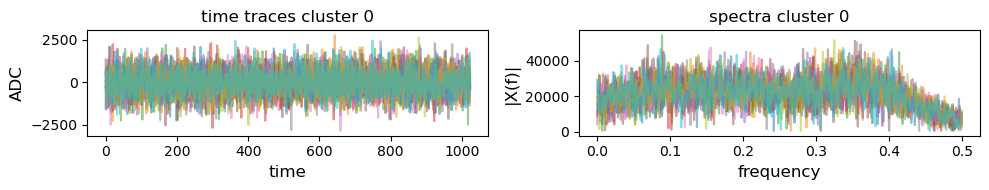

In [3]:
# Plot example traces and the corresponding Fourier spectra of one cluster.
cluster_idx = 0
time_traces_in_cluster=time_traces[true_clusters==cluster_idx]
spectra_in_cluster=spectra[true_clusters==cluster_idx]
fig, ax= plt.subplots(1,2,figsize=(10,2))
for idx in np.random.choice(len(time_traces_in_cluster), size=10, replace=False):
    ax[0].plot(time_axis, time_traces_in_cluster[idx], alpha=0.5)
    ax[1].plot(freq_axis, spectra_in_cluster[idx], alpha=0.5)
ax[0].set_title(f'time traces cluster {cluster_idx}')
ax[0].set_xlabel('time', fontsize=12)
ax[0].set_ylabel('ADC', fontsize=12)
ax[1].set_title(f'spectra cluster {cluster_idx}')
ax[1].set_xlabel('frequency', fontsize=12)
ax[1].set_ylabel('|X(f)|', fontsize=12)
plt.tight_layout()
plt.show()

## Identifying clusters in unlabeled data
> Now, we create a UMAPClassifier instance from a yaml file. All parameters, which shall not take the default values can either be loaded as given arguments or be specified in a separate .yaml file.\
> Afterwards, we take the input data given by the time traces and modify it as we are using it for embedding and cluster identification. It is important that the input type is the correct type from 'time', 'fft', 'fft_time' or 'fft_phase'.

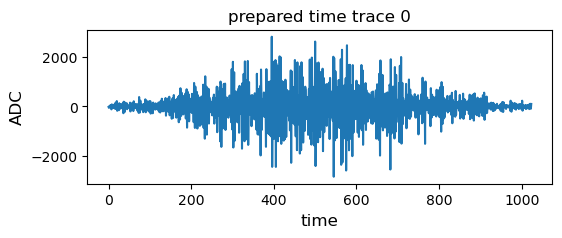

In [4]:
# Create UMAPClassifier instance
u_clas = umap_classifier.UMAPClassifier(yaml_path="../yaml_files/umap_classifier_test.yaml", input_data_type="time")

# The parameters for data preparation can be passed in the data_preparation dictionary.
# E.g. take the time traces, apply a hamming window and suppress the DC component.
prepared_data=u_clas.prepare_data(time_traces, data_preparation={
                'windowing':'hamming',
                'target_data_type':"time",
                'suppress_dc':True},
                verbose=False)
trace_id=0
plt.figure(figsize=(6,2))
plt.plot(time_axis, prepared_data[trace_id])
plt.title(f'prepared time trace {trace_id}')
plt.xlabel('time', fontsize=12)
plt.ylabel('ADC', fontsize=12)
plt.show()


No rd_train_std provided. Calculating std from the provided prepared data.
No rd_train_std provided. Calculating std from the provided prepared data.


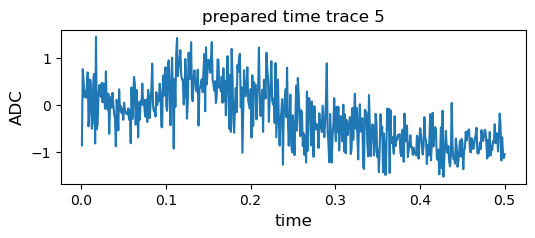

In [5]:
# If changed once, the parameters stay as attributes of the instance. To reset all of the to default values, create a new instance.
u_clas = umap_classifier.UMAPClassifier(yaml_path="../yaml_files/umap_classifier_test.yaml", input_data_type="time")

#Tthe parameters for data preparation can also be passed as separate keyword arguments.
# E.g. take the FFT of the time traces, suppress the DC component and normalize the spectra in z-score fashion.
prepared_data=u_clas.prepare_data(time_traces, 
                target_data_type="fft",
                normalization=True,
                suppress_dc=True,
                verbose=False)
trace_id=5
plt.figure(figsize=(6,2))
plt.plot(freq_axis[1:], prepared_data[trace_id])
plt.title(f'prepared time trace {trace_id}')
plt.xlabel('time', fontsize=12)
plt.ylabel('ADC', fontsize=12)
plt.show()

In [6]:
# During normalization, the mean and std of each feature are computed for normalization of further data according to the same values.
# They can be accessed as follows:
print('mean of first feature after normalization:', u_clas.data_preparation["rd_train_mean"][0])
print('std of first feature after normalization:', u_clas.data_preparation["rd_train_std"][0])


mean of first feature after normalization: 10695.116803863802
std of first feature after normalization: 8974.462310778461


> After preparing the data, we can use UMAP for dimension reduction. For a detailed discussion of the UMAP parameters see the [UMAP Tutorial](https://umap-learn.readthedocs.io/en/latest/parameters.html).

In [7]:
%%capture output
# Create UMAP embeddings
embeddings=u_clas.embed(prepared_data)

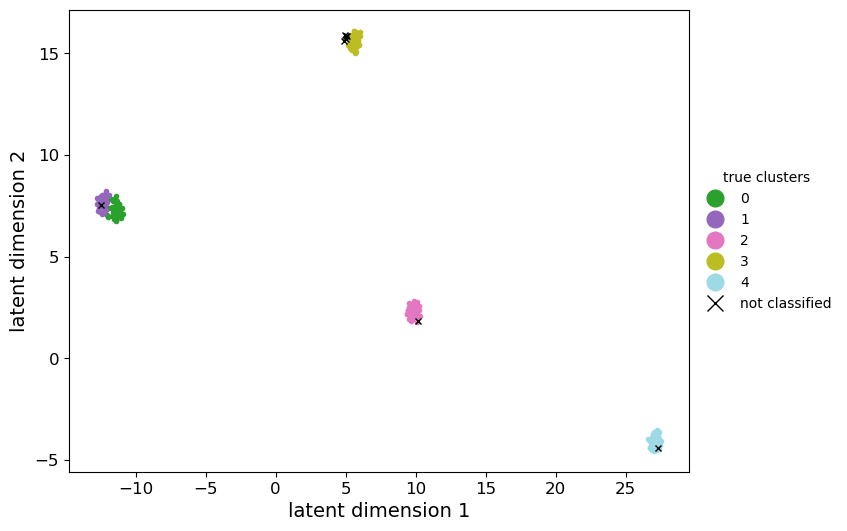

In [8]:
# We can visualize the embeddings in a 2D scatter plot.
fig, ax = u_clas.plot_embedding(embeddings, labels=true_clusters, label_type='categorical', label_name="true clusters", alpha=1)

We are now ready to identify the clusters in the low the latent space. Therefor, currently implemented methods are DBSCAN and HDBSCAN.

Overriding db_min_samples with value 10 from kwargs.
Overriding db_eps with value 0.5 from kwargs.


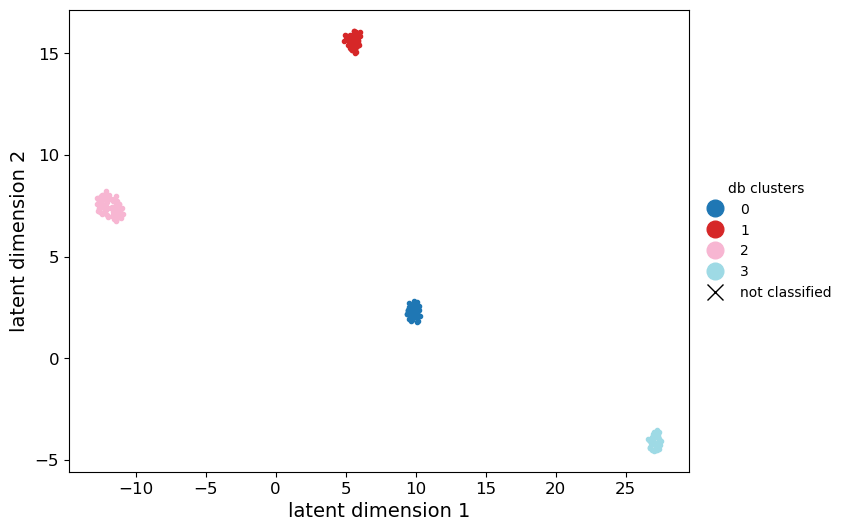

In [9]:
# Using DBSCAN for clustering
db_clusters=u_clas.db_classify(embeddings, db_min_samples=10, db_eps=0.5)
fig, ax = u_clas.plot_embedding(embeddings, labels=db_clusters, label_type='categorical', label_name="db clusters", alpha=1)

**Visualization**
> In order to visualize the output, we propose several methods. 

In [10]:
# First, we have to save the cluster proberpties, we want to display. These can be computed from the training data and be something like the mean and std of each feature in a cluster.
u_clas.save_cluster_trace(prepared_data, db_clusters, trace_statistic="mean")
u_clas.save_cluster_trace(prepared_data, db_clusters, trace_statistic="median")
u_clas.save_cluster_trace(prepared_data, db_clusters, trace_statistic="std")
u_clas.save_cluster_trace(prepared_data, db_clusters, trace_statistic="quantile", q=0.1)
u_clas.save_cluster_trace(prepared_data, db_clusters, trace_statistic="quantile", q=0.9)

Saved 4 cluster traces with mean statistic.
Saved 4 cluster traces with median statistic.
Saved 4 cluster traces with std statistic.
Saved 4 cluster traces with quantile statistic.
Saved 4 cluster traces with quantile statistic.


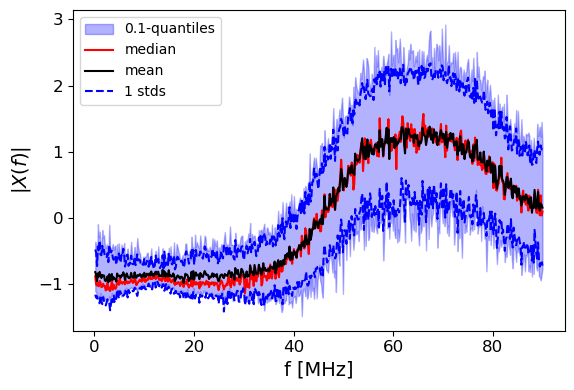

In [11]:
# This plot style can show the mean, medians, std and quantiles of a cluster.
fig, ax = u_clas.plot_spectra(0, q=0.1, sigma=1)
ax[0].set_yscale('linear')
plt.show()

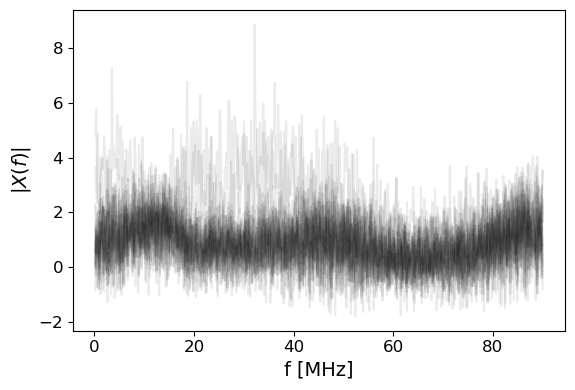

In [12]:
# This plot style can show individual samples of a cluster.
fig, ax=u_clas.plot_cluster_samples(prepared_data, db_clusters, cluster_idx=1, n_samples=20, alpha=0.08)
ax[0].set_yscale('linear')
plt.show()

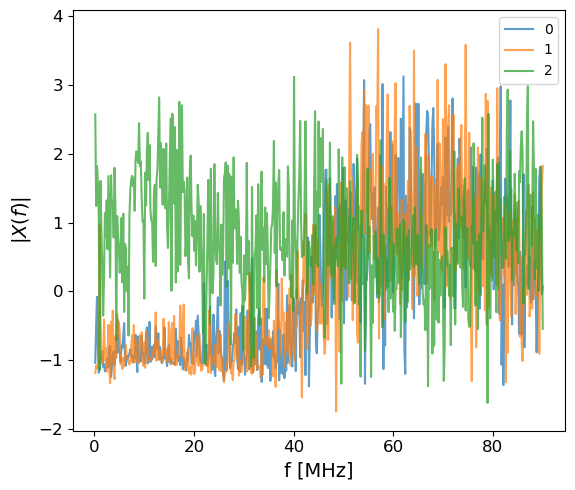

In [13]:
# It is also possible to plot specified traces by their index in the dataset.
fig, ax = u_clas.plot_index(prepared_data, index = [0,1,2])
ax[0].set_yscale('linear')
plt.show()

In [14]:
# Finally, we can use a bokeh based interactive plot to explore the clusters and their properties.
u_clas.plot_overview_bokeh(embeddings, index=list(range(len(embeddings))), cluster=db_clusters, color_key='cluster', true_cluster=true_clusters,)

Loading BokehJS ...

### Predict cluster labels of new data
> Here, we present three different methods, how to predict the cluster labels from new data:
> - UMAP.transform together with DBSCAN
> - Minimum Distance Classifiers
> - Maximum Likelihood Classifiers
> 
> Thereby, we will also discuss how to identify outliers with these methods

In [15]:
# Prepare the test data in the same way as the training data.
# As one can see the parameters for normalization and data preparation are stored as attributes of the instance.
prepared_test_data=u_clas.prepare_data(test_time_traces, verbose=False)

Using previous rd_train_mean and rd_train_std for normalization.


**UMAP.transform**
>The first approach is to use the inherent method, which UMAP provides to embed new data, and the existing DBSCAN model in order to predict cluster labels for new data.

In [16]:
%%capture output
# Predict clusters for new data
# The first approach is to use the inherent method, which UMAP provides to embed new data, and the existing DBSCAN model in order to predict cluster labels for new data.
# Increase db_eps if too many outliers are detected.

pred_clusters, pred_embeddings=u_clas.umap_transform_prediction(prepared_test_data, db_eps=2)

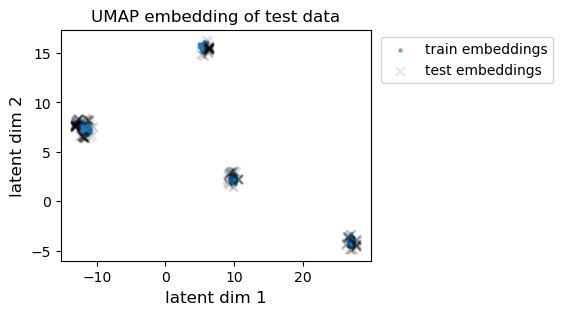

In [17]:
# Plot the embeddings of the test data
plt.figure(figsize=(4,3))
plt.scatter(embeddings[:,0], embeddings[:,1], s=5, label='train embeddings', alpha=0.5)
plt.scatter(pred_embeddings[:,0], pred_embeddings[:,1], s=40, label='test embeddings', alpha=0.1, marker='x', color="k")

plt.title('UMAP embedding of test data')
plt.xlabel('latent dim 1', fontsize=12)
plt.ylabel('latent dim 2', fontsize=12)
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.show()

**Minimum Distance Classifiers**\
Classification is performed based on minimal distance to mean/median trace of the previously defined clusters.

In [18]:
u_clas.prepare_minimum_distance_prediction(prepared_data, db_clusters, metric="euclidean", trace_statistic="mean")

In [19]:
# Therefore, we first have to prepare the prediction method. 
# This includes saving the cluster traces, if not done already 
# and the median distance from each point in the training data to its cluster trace.
u_clas.prepare_minimum_distance_prediction(prepared_data, db_clusters, metric="euclidean", trace_statistic="mean")
predictions, min_distances=u_clas.minimum_distance_prediction(prepared_data, max_distance=0.2, noise_alpha=1, metric="euclidean", trace_statistic="mean")
np.unique(predictions, return_counts=True)

(array([-1,  0,  1,  2,  3]), array([99, 22, 23, 35, 21]))

**Maximum likelihood classifiers**\
These are based on statistical model assumptions for the bin distribution. In the first part we assume a (correlated/uncorrelated) Gaussian distribution. Afterwards, we will also show, how general models can be implemented.

In [20]:
# For a simple uncorrelated Gaussian maximum likelihood classifier, we have to save the mean and std cluster traces.
# This can be done using the prepare_ml_uncorrelated_normal_prediction method.
# Indeed noise_alpha should be close to 1
u_clas.prepare_ml_uncorrelated_normal_prediction(prepared_data, db_clusters, modifier_function_name="", verbose=True)
predictions, mls = u_clas.ml_uncorrelated_normal_prediction(prepared_data, noise_alpha=0.9, min_logl=-10000)
print(sum(predictions == -1), "noise points detected among the training data by ML classifier")
print(f"{sum(predictions == db_clusters)/len(predictions)*100:.3f}% of training data classified correctly by ML classifier")

Calculating median uncorrelated normal likelihoods for each cluster.
8 noise points detected among the training data by ML classifier
96.000% of training data classified correctly by ML classifier


In [21]:
# For the correlated Gaussian maximum likelihood classifier, we have to save the cholesky factors of each cluster.
u_clas.prepare_ml_correlated_normal_prediction(prepared_data, db_clusters, modifier_function_name="", verbose=True)
predictions, mls = u_clas.ml_correlated_normal_prediction(prepared_data, noise_alpha=0.9,min_logl=-1)
print(sum(predictions == -1), "noise points detected among the training data by ML classifier")
print(f"{sum(predictions == db_clusters)/len(predictions)*100:.3f}% of training data classified correctly by ML classifier")

Saved 4 cluster Cholesky factors.
Calculating median correlated normal likelihoods for each cluster.
0 noise points detected among the training data by ML classifier
100.000% of training data classified correctly by ML classifier


> If one is interested in measuring the overall performance on a labeled dataset, one can compute several performance metrics based on a contingency table of true and predicted labels. \
> Furthermore, if each cluster is assigned to the dominant malfunction within this cluster, one can construct the quadratic confusion matrix and use several performance metrics based on the quadratic confusion matrix

In [22]:
# Compute contingency table and confusion matrix of predicted test data
predictions, mls = u_clas.ml_uncorrelated_normal_prediction(prepared_test_data, min_logl=-1)
contingency_table, confusion_matrix=pm.confusion_matrix_from_dominant_cluster_label(test_true_clusters, predictions)
confusion_matrix


predicted,-1,0,1,2,3,4
true,,,,,,
-1,0,0,2,0,10,0
0,0,0,39,0,0,0
1,0,0,45,0,0,0
2,0,0,0,33,0,0
3,0,0,0,0,35,0
4,0,0,0,0,0,36


In [23]:
%%capture output
# Now, we can compute several performance metrics based on the contingency table and the confusion matrix.
# It is possible to specify which label corresponds to normal data, here "0" and which label corresponds to noise points, here "-1".
ps_summary, ps= pm.prediction_performance(confusion_matrix, contingency_table=contingency_table, normal_label="1", verbose=True)

In [24]:
print("Here we print for example the AMI and ARI of the uncorrelated Gaussian ML classifier on the test data:")
print(f"AMI based on confusion matrix: {ps_summary['ami']:.4f}")
print(f"ARI based on confusion matrix: {ps_summary['ari_score']:.4f}")

Here we print for example the AMI and ARI of the uncorrelated Gaussian ML classifier on the test data:
AMI based on confusion matrix: 0.8365
ARI based on confusion matrix: 0.7310


### The ROC curve
> In order to see how well certain prediction methods are able to identify clusters, which are not present in the training data, as outliers, we will create ROC curves. These curves can be created for binary classifiers, which is here the classification between known cluster and unknown outlier or noise.

In [25]:
# Create new data from a cluster not present in the training data
new_time_traces, new_spectra, new_phase, new_true_clusters, _,_=random_rm_trace_generator.generate_random_rm_traces(
    50, n_clusters=1, outlier_fraction=1, noise_level=1)
new_true_clusters=np.repeat(-1, 50)  # Mark all new data as outliers

In [26]:
# Prepare the new data in the same way as the training data.
new_prepared_data=u_clas.prepare_data(new_time_traces, verbose=False)

Using previous rd_train_mean and rd_train_std for normalization.


**UMAP.transorm**

In [27]:
%%capture output
# Predict clusters with umap.transform for different values of db_eps
epsilons = np.linspace(0, 0.8, 1000)
fprs, tprs = [], []

# First calculate the embeddings which is costly and should not be done for every value of eps
new_predictions, new_embs = u_clas.umap_transform_prediction(new_prepared_data, db_eps=0)
test_predictions, test_embs = u_clas.umap_transform_prediction(prepared_test_data[test_true_clusters != -1], db_eps=0)

for eps in epsilons:
    # Set the eps parameter of the existing DBSCAN model to the current value
    u_clas.db_model.set_params(eps=eps)

    # Predict the cluster labels for the new data and the test data without outliers only by the dbscan_predict method
    new_predictions = u_clas._dbscan_predict(u_clas.db_model, new_embs)
    test_predictions = u_clas._dbscan_predict(u_clas.db_model, test_embs)
    true_noise_points = sum(new_predictions == -1)
    false_noise_points = sum(test_predictions == -1)
    tprs.append(true_noise_points/len(new_predictions))
    fprs.append(false_noise_points/len(test_predictions))

AUC: 0.6004


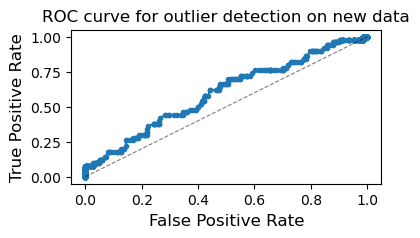

In [28]:
# Hereby, we can create a ROC curve for outlier detection on new data.
plt.figure(figsize=(4,2))
plt.plot(fprs, tprs, ".-")
plt.plot([0,1], [0,1], "--", color="k", alpha=0.5, linewidth=0.8)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC curve for outlier detection on new data')
print(f"AUC: {auc(fprs, tprs):.4f}")
plt.show()

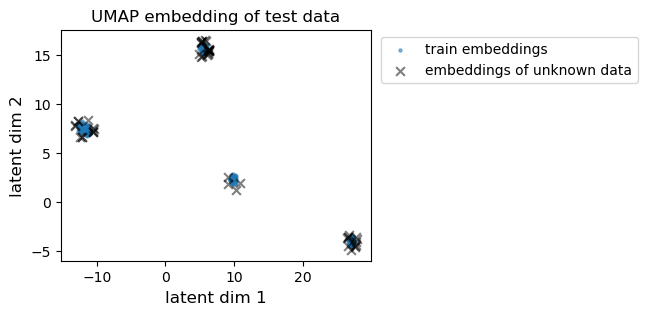

In [29]:
# Plot the embeddings of the test data
plt.figure(figsize=(4,3))
plt.scatter(embeddings[:,0], embeddings[:,1], s=5, label='train embeddings', alpha=0.5)
plt.scatter(new_embs[:,0], new_embs[:,1], s=40, label='embeddings of unknown data', alpha=0.5, marker='x', color="k")

plt.title('UMAP embedding of test data')
plt.xlabel('latent dim 1', fontsize=12)
plt.ylabel('latent dim 2', fontsize=12)
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.show()

> We already remark two fundamental drawbacks of umap.transform.
> - predicting the embedding with umap.transform is costly
> - the ability to detect the unknown malfunction is not much better than random
>
> In order to solve the first problem, we compute the embeddings outside the loop and only adapt the eps value of DBSCAN in order to create the ROC curve. The second problem is inherent, since UMAP has the tendency to embed anomalies onto existing clusters. Therefore, more advanced methods, e.g. [Parametric UMAP](parametric_umap_classifier.ipynb), are necessary.

**ML Classifier**


AUC: 0.9929


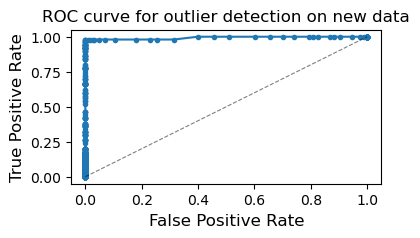

In [30]:
# We plot the ROC curve for outlier detection on new data using the uncorrelated Gaussian ML classifier for different values of noise_alpha.
alphas = np.logspace(-2, 0.1, 1000)
fprs, tprs = [], []
for alpha in alphas:
    new_predictions, new_mls = u_clas.ml_uncorrelated_normal_prediction(new_prepared_data, noise_alpha=alpha)
    test_predictions, test_mls = u_clas.ml_uncorrelated_normal_prediction(prepared_test_data[test_true_clusters != -1], noise_alpha=alpha)
    true_noise_points = sum(new_predictions == -1)
    false_noise_points = sum(test_predictions == -1)
    tprs.append(true_noise_points/len(new_predictions))
    fprs.append(false_noise_points/len(test_predictions))
plt.figure(figsize=(4,2))
plt.plot(fprs, tprs, ".-")
plt.plot([0,1], [0,1], "--", color="k", alpha=0.5, linewidth=0.8)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC curve for outlier detection on new data')
print(f"AUC: {auc(fprs, tprs):.4f}")
plt.show()
